In [502]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line
from skimage import data
from skimage.io import imread, imsave

import matplotlib.pyplot as plt
from matplotlib import cm

guardar_resultados_intermedios = True

path_recorte_base = "recortes/"
path_resultados_intermedios = "resultados_intermedios/"
filename = 'Imagenes/6_luz.jpg'

image = imread(filename, as_gray=True)
print(f"Abriendo {filename} - tamaño de la imagen: {image.shape}, tipo de la imagen: {image.dtype}\n")


Abriendo Imagenes/6_luz.jpg - tamaño de la imagen: (4624, 3472), tipo de la imagen: float64



In [503]:
# Encontramos los bordes con el filtro de Canny:
edges = canny(image, 2, 1/255, 25/255)

# Usando la transformada de Hough encontramos las rectas principales (0.5° de presición)
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(edges, theta=tested_angles)


Lineas obtenidas a partir de hough
	Recta: d=300.526, ang=-0.017 centro=(300.480,-5.245)
	Recta: d=3145.772, ang=0.026 centro=(3144.694,82.347)
	Recta: d=4329.874, ang=1.562 centro=(37.785,4329.709)
	Recta: d=-410.535, ang=-1.553 centro=(-7.165,410.473)

Lineas obtenidas a partir de hough - Radios y angulos positivos
	Recta: d=300.526, ang=3.124, m=57.290, c=-17219.745
	Recta: d=3145.772, ang=0.026, m=-38.188, c=120173.366
	Recta: d=4329.874, ang=1.562, m=-0.009, c=4330.039
	Recta: d=410.535, ang=1.588, m=0.017, c=410.598

Puntos de intersección:
	x0=376.096, y0=4326.757
	x0=307.833, y0=415.971
	x0=3034.158, y0=4303.561
	x0=3134.666, y0=465.314


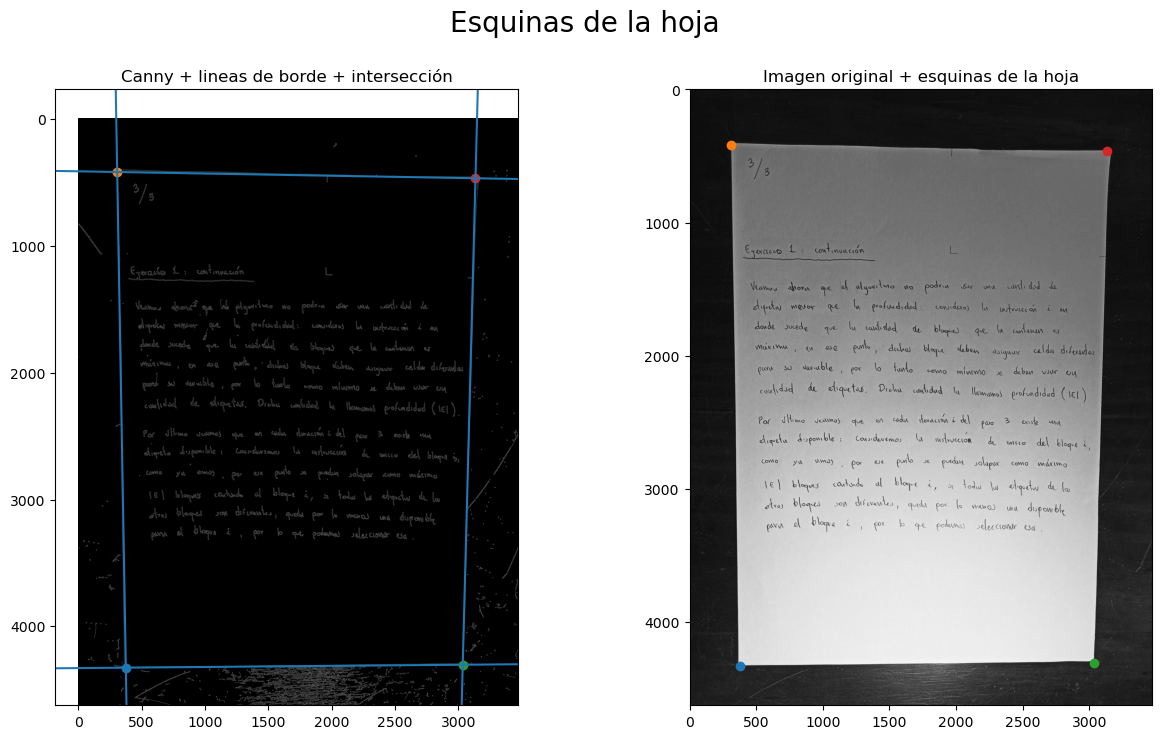

In [504]:
# Ploteamos las lineas de Hough encontradas e intersectamos las 4 de mayor relevancia
# suponiendo que son los bordes de la hoja:

figura, plots = plt.subplots(1, 2, figsize=(15,8))
figura.suptitle("Esquinas de la hoja", fontsize=20)

plots[0].imshow(edges, cmap='gray')
plots[0].set_title("Canny + lineas de borde + intersección")

plots[1].imshow(image, cmap='gray')
plots[1].set_title("Imagen original + esquinas de la hoja")

print("Lineas obtenidas a partir de hough")

l_angulos_radios = []
for _, angle, dist in zip(*hough_line_peaks(h, theta, d, min_distance=50, threshold=0.3*np.max(h))):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    plots[0].axline((x0, y0), slope=np.tan(angle + np.pi/2))
    print(f"\tRecta: d={dist:.3f}, ang={angle:.3f} centro=({x0:.3f},{y0:.3f})")
    
    ang = angle
    if ang < 0:
        ang += np.pi
    radio = dist
    if radio < 0:
        radio = radio * (-1)
    m = -np.tan((np.pi/2)-ang)
    c = y0 - (m*x0)
    l_angulos_radios.append((ang, radio, m, c))

print("\nLineas obtenidas a partir de hough - Radios y angulos positivos")
for linea in l_angulos_radios:
    print(f"\tRecta: d={linea[1]:.3f}, ang={linea[0]:.3f}, m={linea[2]:.3f}, c={linea[3]:.3f}")

    
# Puntos de intersección:

print("\nPuntos de intersección:")

puntos_inter = []

for i in range(0,4):
    ang1 = l_angulos_radios[i][0]
    rad1 = l_angulos_radios[i][1]
    m1 = l_angulos_radios[i][2]
    c1 = l_angulos_radios[i][3]
    
    for j in range(i,4):
        ang2 = l_angulos_radios[j][0]
        rad2 = l_angulos_radios[j][1]
        m2 = l_angulos_radios[j][2]
        c2 = l_angulos_radios[j][3]
        
#         if (ang1>ang2+(np.pi/8)) or (ang1<ang2-(np.pi/8)):
        if (np.abs(ang1-ang2) > np.pi/8):
            
            # Si dos lineas tienen ángulos similares es porque son paralelas y
            # por lo tanto no se deben intersectar.

            xint = (c1-c2)/(m2-m1)
            yint = (m1*xint) + c1
            # descartar los puntos que quedan fuera de la imagen
            if ( (0<xint<image.shape[1]) and (0<yint<image.shape[0]) ):
                plots[0].scatter([xint], [yint], cmap='r')
                plots[1].scatter([xint], [yint], cmap='r')
                puntos_inter.append([xint, yint])
                print(f"\tx0={xint:.3f}, y0={yint:.3f}")

plt.show()

if guardar_resultados_intermedios:
    
    # Save the full figure...
    figura.savefig(path_resultados_intermedios + 'full_hough_esquinas.png')

    # Save plot 1
    extent = plots[0].get_window_extent().transformed(figura.dpi_scale_trans.inverted())
    figura.savefig(path_resultados_intermedios + "hough.png", bbox_inches=extent)

    # Save plor 2
    extent = plots[1].get_window_extent().transformed(figura.dpi_scale_trans.inverted())
    figura.savefig(path_resultados_intermedios + "esquinas.png", bbox_inches=extent)


In [505]:
# Calculamos la homografia que lleva las esquinas de la hoja a las esquinas
# de una imagen de proporciones iguales a una hoja A4. El tamaño que seleccionamos
# para la imagen es 2100 x 2970, lo cual corresponde a 100 pixeles por mm2.

import cv2

# Primero hay que ordenar los puntos para corresponderlos con las esquinas de una hoja A4

A4_x_max = 2099 # 2100 x 2970
A4_y_max = 2969

x_mean = np.mean(np.array(puntos_inter)[:,0])
y_mean = np.mean(np.array(puntos_inter)[:,1])

pts_src = np.array(puntos_inter)
pts_dst = np.zeros(shape=pts_src.shape, dtype=pts_src.dtype)

for punto in range(0,pts_src.shape[0]):
    
    i = pts_src[punto,0]
    j = pts_src[punto,1]
    
    if (i<x_mean) and (j<y_mean):
        pts_dst[punto,0] = 0
        pts_dst[punto,1] = 0
    
    elif (i>x_mean) and (j<y_mean):
        pts_dst[punto,0] = A4_x_max
        pts_dst[punto,1] = 0
        
    elif (i<x_mean) and (j>y_mean):
        pts_dst[punto,0] = 0
        pts_dst[punto,1] = A4_y_max
    
    elif (i>x_mean) and (j>y_mean):
        pts_dst[punto,0] = A4_x_max
        pts_dst[punto,1] = A4_y_max

# Calcular la matriz de transformación:

h, status = cv2.findHomography(pts_src, pts_dst)

# Aplicar la transformación:

im_out = np.zeros(shape=(A4_y_max,A4_x_max), dtype=image.dtype)
im_out = cv2.warpPerspective(image, h, (im_out.shape[1],im_out.shape[0]))


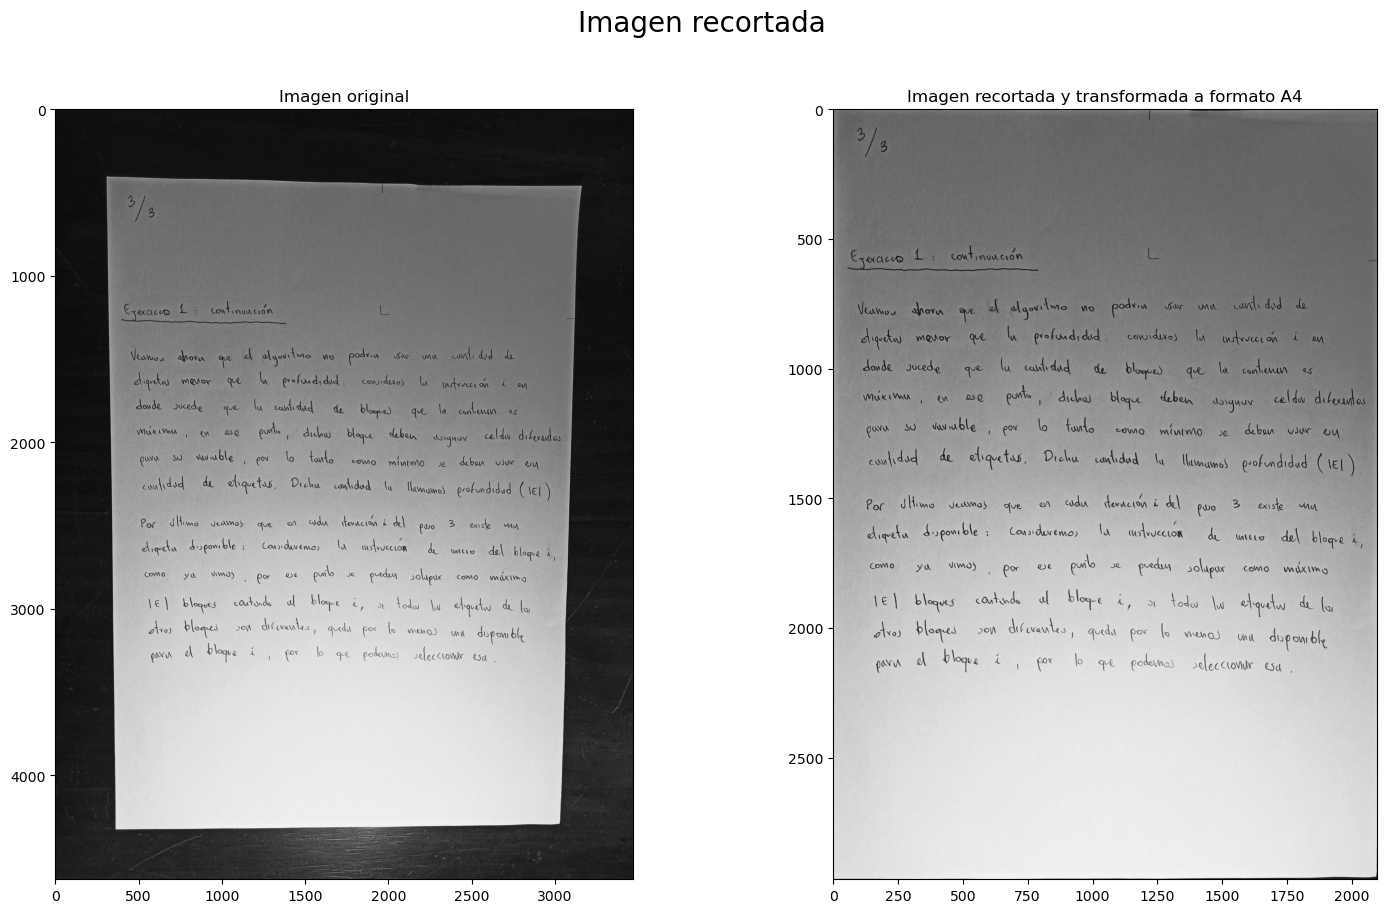

In [506]:
# Plotear:

figura, plots = plt.subplots(1, 2, figsize=(18,10))
figura.suptitle("Imagen recortada", fontsize=20)

plots[0].imshow(image, cmap='gray')
plots[0].set_title("Imagen original")

plots[1].imshow(im_out, cmap='gray')
plots[1].set_title("Imagen recortada y transformada a formato A4")

plt.show()

if guardar_resultados_intermedios:
    
    # Save the full figure...
    figura.savefig(path_resultados_intermedios + 'full_recorte.png')

    # Save plot 1
    extent = plots[1].get_window_extent().transformed(figura.dpi_scale_trans.inverted())
    figura.savefig(path_resultados_intermedios + "recorte.png", bbox_inches=extent)



In [507]:
# Función auxiliar para obtener el indice de inicio y fin de cada intervalo
# correspondiente a la división de un intervalo más grande.

def dividir_intervalo(indice_inicial, indice_final, num_elem):
    
    lista_resu = []
    fin = False
    index_i = indice_inicial
    
    while not fin:
        index_f = index_i + num_elem - 1
        if index_f > indice_final:
            fin = True
            lista_resu.append((index_i, indice_final))
        else:
            lista_resu.append((index_i, index_f))
            index_i = index_f + 1
            if index_i > indice_final:
                fin = True
    
    return lista_resu

# print(dividir_intervalo(indice_inicial=0, indice_final=100, num_elem=20))

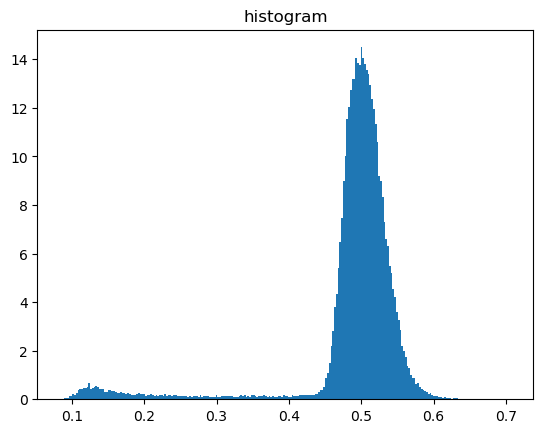

In [508]:
# Umbralización local:

# Para hacernos una idea de la forma del histograma en las distintas regiones
# es que ploteamos un histograma de los valores de grises de la región.

tam_reg = 300
x_list = [i for i in range(0,im_out.shape[1]+1)]
y_list = [i for i in range(0,im_out.shape[0]+1)]
x_chunk_list = dividir_intervalo(0,A4_x_max, tam_reg)
y_chunk_list = dividir_intervalo(0,A4_y_max, tam_reg)

region_aux = im_out[y_chunk_list[2][0]:y_chunk_list[2][1], x_chunk_list[2][0]:x_chunk_list[2][1]]

# Ploteo:

plt.hist(region_aux.flatten(), density=True, bins=255) 
plt.title("histogram") 
plt.show()



In [509]:
from skimage.filters import threshold_otsu

# Función para obtener una binarización de la imagen aplicando un método local.

def binarizar(img_in, tam_reg, dtype_out='uint8'):
    
    x_list = [i for i in range(0,img_in.shape[1])]
    y_list = [i for i in range(0,img_in.shape[0])]

    # print(f"x_list: {x_list[0]} - {x_list[1]} - img_in.shape[1]={img_in.shape[1]}")
    # print(f"y_list: {y_list[0]} - {y_list[1]} - img_in.shape[0]={img_in.shape[0]}")
    
    x_chunk_list = dividir_intervalo(0,A4_x_max, tam_reg)
    y_chunk_list = dividir_intervalo(0,A4_y_max, tam_reg)
    
    # print(x_chunk_list)
    # print(y_chunk_list)
    
    # im_bin = np.zeros_like(im_out)
    im_bin = np.zeros(shape=im_out.shape, dtype=dtype_out)

    for y_chunk in y_chunk_list:
        for x_chunk in x_chunk_list:
            
            x_inf = x_chunk[0]
            x_sup = x_chunk[1]+1
            y_inf = y_chunk[0]
            y_sup = y_chunk[1]+1
            p_count = (y_sup - y_inf) * (x_sup - x_inf)
            
            # Calculamos el umbral de binarización de la región con el método de Otsu:
            thresh = threshold_otsu(im_out[y_chunk[0]:y_chunk[1],x_chunk[0]:x_chunk[1]])
            im_bin[y_inf:y_sup,x_inf:x_sup] = img_in[y_inf:y_sup,x_inf:x_sup] > thresh
            
            # En regiones donde no hay trazo del lapiz, el umbral elegido reparte una
            # proporción similar de pixeles blancos y negros. Es por eso que en caso
            # de encontrar muchos pixeles negros, suponemos que se trata de un error
            # y llevamos la región a blanco. La suposición es que no hay más de 20% de
            # pixeles negros en una región.
            w_count = np.count_nonzero(im_bin[y_inf:y_sup,x_inf:x_sup])
            if w_count < (p_count * 0.8):
                im_bin[y_inf:y_sup,x_inf:x_sup] = True
    
    return im_bin
            

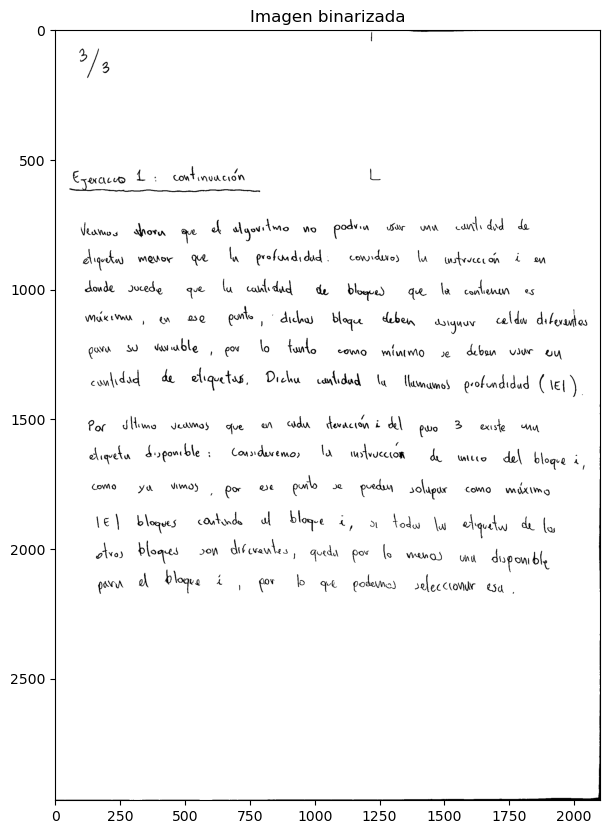

In [510]:
im_bin = binarizar(im_out, tam_reg=100)
# imsave('prueba_bin.png', im_bin)

# Plotear:

figura, plots = plt.subplots(1, 1, figsize=(18,10))

plt.imshow(im_bin, cmap='gray')
plots.set_title("Imagen binarizada")

plt.show()

if guardar_resultados_intermedios:

    # Save plot 0
    extent = plots.get_window_extent().transformed(figura.dpi_scale_trans.inverted())
    figura.savefig(path_resultados_intermedios + "bin.png", bbox_inches=extent)


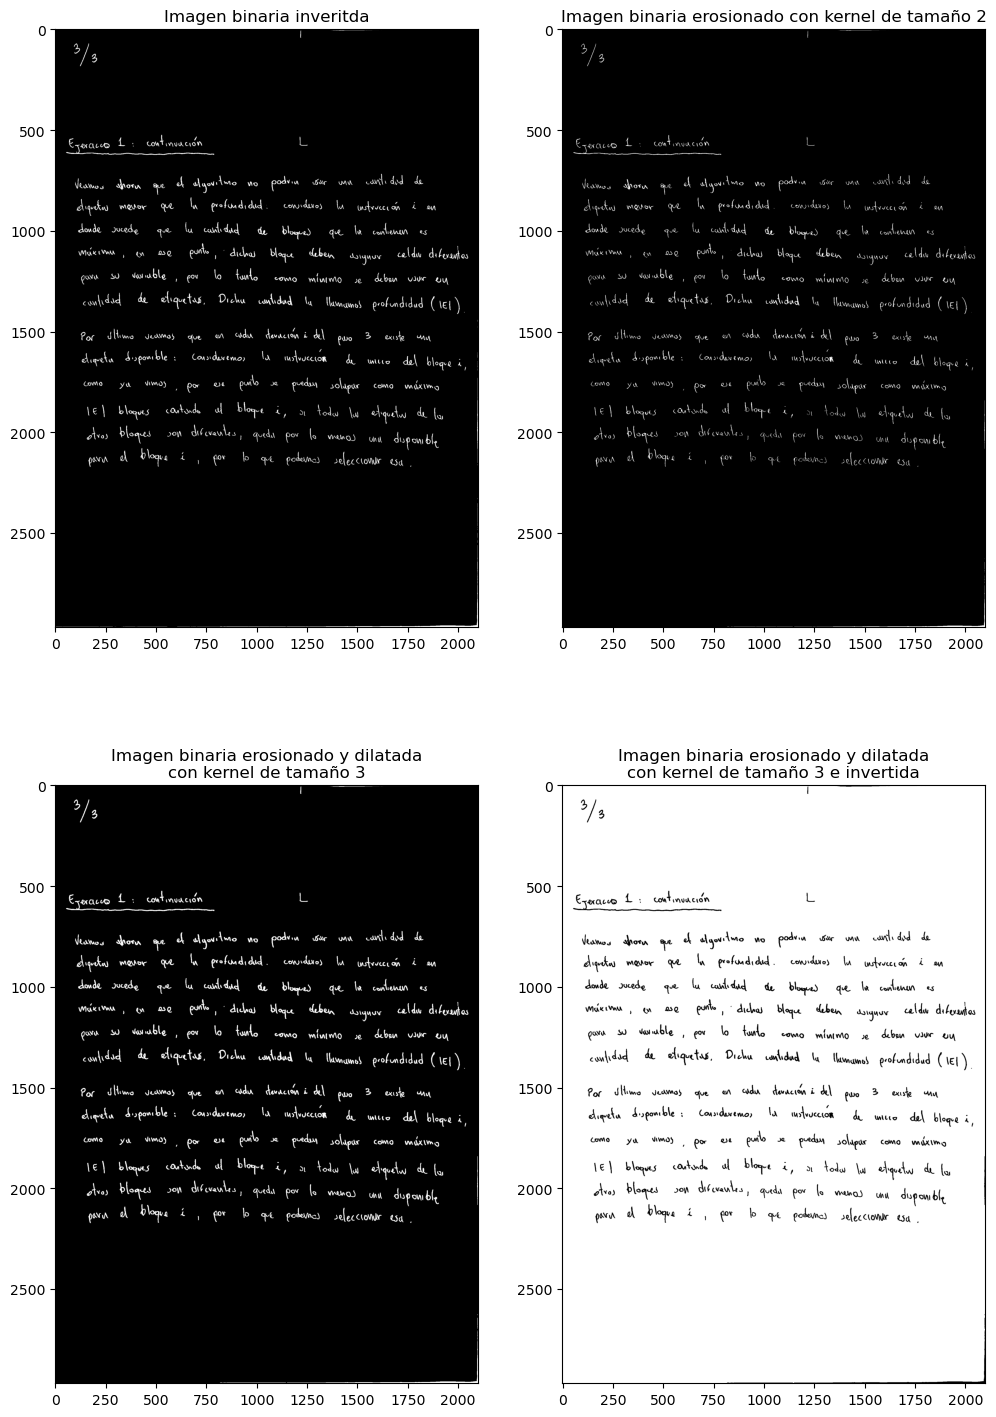

In [511]:
# Para eliminar puntos aislados e impurezas es que aplicamos primero una erosión sobre
# la binarización obtenida, y luego un dilatación para recuperar el grosor que perdimos
# de las letras con la primera operación.

size_ero = 2
size_dil = 3

ero_kernel = np.ones((size_ero,size_ero), np.uint8)
dil_kernel = np.ones((size_dil,size_dil), np.uint8)

# Es necesario invertir la imagen para que el "objeto" erosionado sean las letras
# y no el fondo:
img_bin_inv = 1 - im_bin
img_ero = cv2.erode(img_bin_inv, ero_kernel, iterations=1)
img_ero_dil = cv2.dilate(img_ero, dil_kernel, iterations=1)
img_morf = 1 - img_ero_dil

# Plotear:

figura, plots = plt.subplots(2, 2, figsize=(12,18))

plots[0,0].imshow(img_bin_inv, cmap='gray')
plots[0,0].set_title("Imagen binaria inveritda")

plots[0,1].imshow(img_ero, cmap='gray')
plots[0,1].set_title(f"Imagen binaria erosionado con kernel de tamaño {size_ero}")

plots[1,0].imshow(img_ero_dil, cmap='gray')
plots[1,0].set_title(f"Imagen binaria erosionado y dilatada\ncon kernel de tamaño {size_dil}")

plots[1,1].imshow(img_morf, cmap='gray')
plots[1,1].set_title(f"Imagen binaria erosionado y dilatada\ncon kernel de tamaño {size_dil} e invertida")

plt.show()

if guardar_resultados_intermedios:
    
    # Save the full figure...
    figura.savefig(path_resultados_intermedios + 'full_morfologias.png')

    # Save plot 1
    extent = plots[0,0].get_window_extent().transformed(figura.dpi_scale_trans.inverted())
    figura.savefig(path_resultados_intermedios + "bin_inv.png", bbox_inches=extent)

    # Save plor 2
    extent = plots[0,1].get_window_extent().transformed(figura.dpi_scale_trans.inverted())
    figura.savefig(path_resultados_intermedios + "ero_inv.png", bbox_inches=extent)
    
    # Save plor 3
    extent = plots[1,0].get_window_extent().transformed(figura.dpi_scale_trans.inverted())
    figura.savefig(path_resultados_intermedios + "ero_dil_inv.png", bbox_inches=extent)
    
    # Save plor 4
    extent = plots[1,1].get_window_extent().transformed(figura.dpi_scale_trans.inverted())
    figura.savefig(path_resultados_intermedios + "ero_dil.png", bbox_inches=extent)

Cantidad de CC (componentes conexas): 593


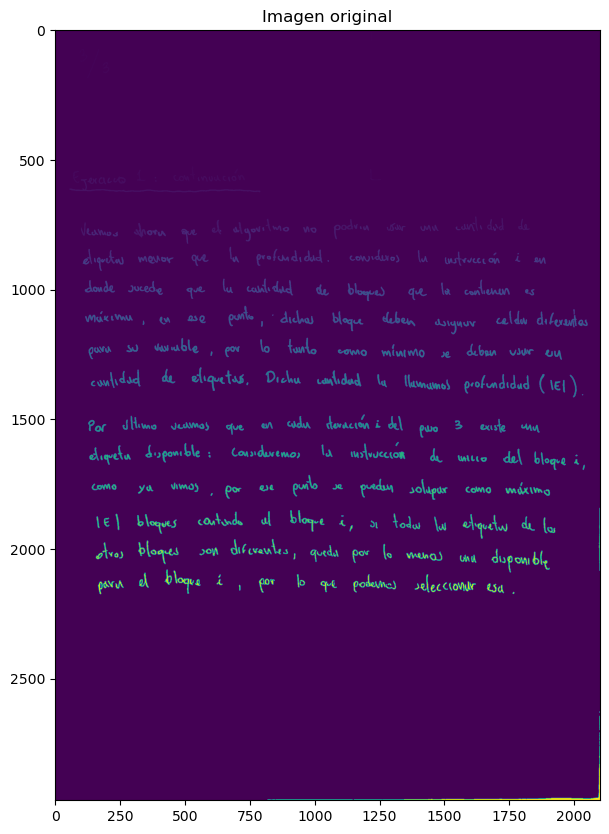

In [512]:
import skimage
from skimage.measure import label, regionprops

# Encontramos las componentes conexas en la imagen binarizada y calculamos sus propiedas,
# tales como: centroide, rectángulo contenedor(bbox) y otras más que nos devuelve la función
# regionprops pero que no utilizamos.

labels, num = label(img_morf, background=1, return_num=True, connectivity=None) 
props = regionprops(labels)

print(f"Cantidad de CC (componentes conexas): {num}")

# Plotear:

figura, plots = plt.subplots(1, 1, figsize=(18,10))

plt.imshow(labels)
plots.set_title("Imagen original")

plt.show()

if guardar_resultados_intermedios:
    
    # Save the full figure...
    figura.savefig(path_resultados_intermedios + 'full_cc.png')

    # Save plot 1
    extent = plots.get_window_extent().transformed(figura.dpi_scale_trans.inverted())
    figura.savefig(path_resultados_intermedios + "cc.png", bbox_inches=extent)


In [513]:
from scipy.spatial import distance_matrix

# Cálculo de la distancia MRL (descrita en el artículo de referencia) entre las
# diferentes etiquetas. Cuando las CC no comparten coordenas verticales, la distancia
# MRL entre ambas etiquetas(que representan CC) la definimos como 0 y deberá ser
# trata como un caso especial cuando se utilice la función. Regresa una matriz con la
# distancia MRL entre las componentes conexas i y j en la entrada [i,j] con i<j. Solamente
# se utiliza la diagonal superior.
def MRL_over_labeled_image(img_label, num_labels):
    
    MRL_matrix = np.zeros(shape=(num_labels, num_labels))
    cant_filas = img_label.shape[0]
    cant_columnas = img_label.shape[1]
    
    for fila in range(0,cant_filas):
        puntero_aux = -1
        for columna in range(0,cant_columnas):
            if img_label[fila,columna] != 0: # Supongo que la etiqueta 0 es el fondo
                if puntero_aux == -1:
                    puntero_aux = columna
                elif img_label[fila,columna] == img_label[fila,puntero_aux]:
                    puntero_aux = columna
                else:
                    j_index = min(img_label[fila,columna],img_label[fila,puntero_aux]) - 1
                    i_index = max(img_label[fila,columna],img_label[fila,puntero_aux]) - 1
                    distancia = columna - puntero_aux
                    if (MRL_matrix[j_index, i_index] == 0) or (MRL_matrix[j_index, i_index] > distancia):
                        MRL_matrix[j_index, i_index] = distancia
                    puntero_aux = columna

    return MRL_matrix

# Cálculo de la distancia euclidia entre los centriodes de las distintas CC. Regresa
# una matriz con la distancia entre las CC i y j en la entrada [j,i] o [i,j]
def distancia_euclidia(label_prop):
    
    coord_list = [prop.centroid for prop in label_prop]
    return distance_matrix(coord_list, coord_list)

# Cálculo del parámetro w descrito en el articulo de referencia. Regresa una matriz
# con el w correspondiente entre las CC i y j en la entrada [i,j] si i<j. Solamente se 
# utiliza la diagonal superior.
def obtener_w(label_prop):
    
    cant_label = len(label_prop)
    w_matrix = np.zeros(shape=(cant_label,cant_label), dtype='float')
    
    for l1 in range(0,cant_label-1):
        for l2 in range(l1+1,cant_label):
            
            label1 = label_prop[l1]
            label2 = label_prop[l2]
            
            # bbox = (min_row, min_col, max_row, max_col)
            # print(f"l1 - techo:{label1.bbox[2]} - piso:{label1.bbox[0]}")
            # print(f"l2 - techo:{label2.bbox[2]} - piso:{label2.bbox[0]}")
            h1 = label1.bbox[2] - label1.bbox[0]
            h2 = label2.bbox[2] - label2.bbox[0]
            ovlp = min(label1.bbox[2], label2.bbox[2]) - max(label1.bbox[0], label2.bbox[0])
            span = max(label1.bbox[2], label2.bbox[2]) - min(label1.bbox[0], label2.bbox[0])
            vdc = abs(label1.centroid[0] - label2.centroid[0])
            # print(f"h1:{h1} - h2:{h2} - ovlp:{ovlp} - span:{span} - vdc:{vdc}")
            
            novlp = 0.5*((ovlp/h1)+(ovlp/h2)) - (vdc/span)
            w = (novlp+1)/2
            
            w_matrix[l1,l2] = w
    
    return w_matrix

# Cálculo de la distancia D descrita en el artículo de referencia. Regresa una matriz
# con la distancia D correspondiente entre las CC i y j en la entrada [i,j] si i<j. 
# Solamente se utiliza la diagonal superior.
def distancia_D(img_label, label_prop):
    
    cant_labels = len(label_prop)
    MRL_matrix = MRL_over_labeled_image(img_label, cant_labels)
    ed_matrix = distancia_euclidia(label_prop)
    w_matrix = obtener_w(label_prop)
    
    D_matrix = np.zeros_like(w_matrix)
    
    for l1 in range(0,cant_labels-1):
        for l2 in range(l1+1,cant_labels):
            
            w = w_matrix[l1,l2]
            mrl = MRL_matrix[l1,l2]
            ecc = ed_matrix[l1,l2]
            
            if mrl == 0: # Para este par de etiquetas no existe una medida de MRL
                D_matrix[l1,l2] = ecc
            else:
                D_matrix[l1,l2] = w*mrl + (1-w)*ecc
    
    return D_matrix
    

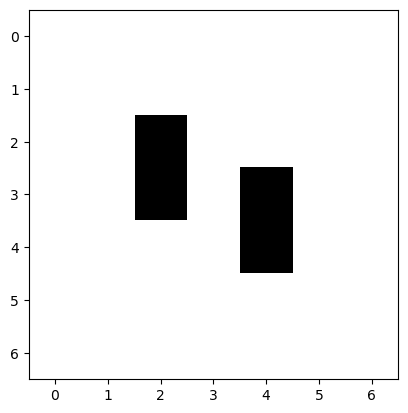

centroide 1 = (2.5, 2.0)

centroide 2 = (3.5, 4.0)

distancia euclidia = 
[[0.         2.23606798]
 [2.23606798 0.        ]]

w = 
[[0.         0.58333333]
 [0.         0.        ]]

Distancia D = 
[[0.         2.09836166]
 [0.         0.        ]]



In [514]:
# Prueba de la función distancia_D y sus auxiliares:

from skimage.measure import label, regionprops

imagen_prueba = np.ones(shape=(7,7), dtype='int')
imagen_prueba[2:4,2] = 0
imagen_prueba[3:5,4] = 0

# Ploteo:

plt.imshow(imagen_prueba, cmap='gray')
plt.show()

# Cálculo de CC, propiedades y distancias:

labels_aux, num_aux = label(imagen_prueba, background=1, return_num=True, connectivity=None)
props_aux = regionprops(labels_aux)

for prop in props_aux:
    print(f"centroide {prop.label} = {prop.centroid}\n")

print(f"distancia euclidia = \n{distancia_euclidia(props_aux)}\n")

print(f"w = \n{obtener_w(props_aux)}\n")

print(f"Distancia D = \n{distancia_D(labels_aux, props_aux)}\n")

# Verificamos que el cálculo a mano coincide con el obtenido por las funciones.

In [515]:
# Creamos el grafo para correr MST(Minimum spanning tree):

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

# Para esta parte pensamos las CC de la imagen como nodos del grafo, y la
# distancia D como la distancia entre los mismos. Luego el algoritmo de MST
# va a dejar solamente aquellas aristas que generan que el grafo continue siendo
# conexo, pero de manera tal que las aristas utilizadas sean de distancia total
# mínima.

# De esta manera obtenemos que las CC se unen mayoritariamente sobre la linea de
# texto, dado que la distancia D se define de forma tal que sea más chica cuando
# el objeto se encuentra alineado verticalemente con el otro.

D_matrix = distancia_D(labels, props)

graph_mat = csr_matrix(D_matrix)
mst_graph_mat = minimum_spanning_tree(graph_mat).toarray()


In [516]:
# El artículo de referencia plantea un método de refinamiento el cual es computacionalmente
# intenso y no se justifica utilizarlo para la calidad de imágenes con las que contamos.
# Por esa razón optamos por utilizar un refinamiento básico, el cual elimina las aristas
# de pendiente mayor a pi/4. Recordar que MST devuelve un grafo conexo, y nosotros queremos
# extraer varios grafos, uno por cada linea de texto.

def MST_refinamiento_basico(mst_graph_mat, prop_list, lim_angle=np.pi/4):
    
    cant_labels = len(prop_list)
    mst_ref_graph_mat = np.zeros_like(mst_graph_mat)
    
    for l1 in range(0,cant_labels-1):
        for l2 in range(l1+1,cant_labels):
            if mst_graph_mat[l1,l2] != 0:

                l1_x = props[l1].centroid[1]
                l1_y = props[l1].centroid[0]
                l2_x = props[l2].centroid[1]
                l2_y = props[l2].centroid[0]
                
                delta_y = abs(l2_y-l1_y)
                delta_x = abs(l2_x-l1_x)
                
                if delta_x != 0:
                    abs_angle = np.arctan(delta_y/delta_x)
                else:
                    abs_angle = np.pi/2
                
                if abs_angle < lim_angle:
                    mst_ref_graph_mat[l1,l2] = mst_graph_mat[l1,l2]
    
    return mst_ref_graph_mat
            

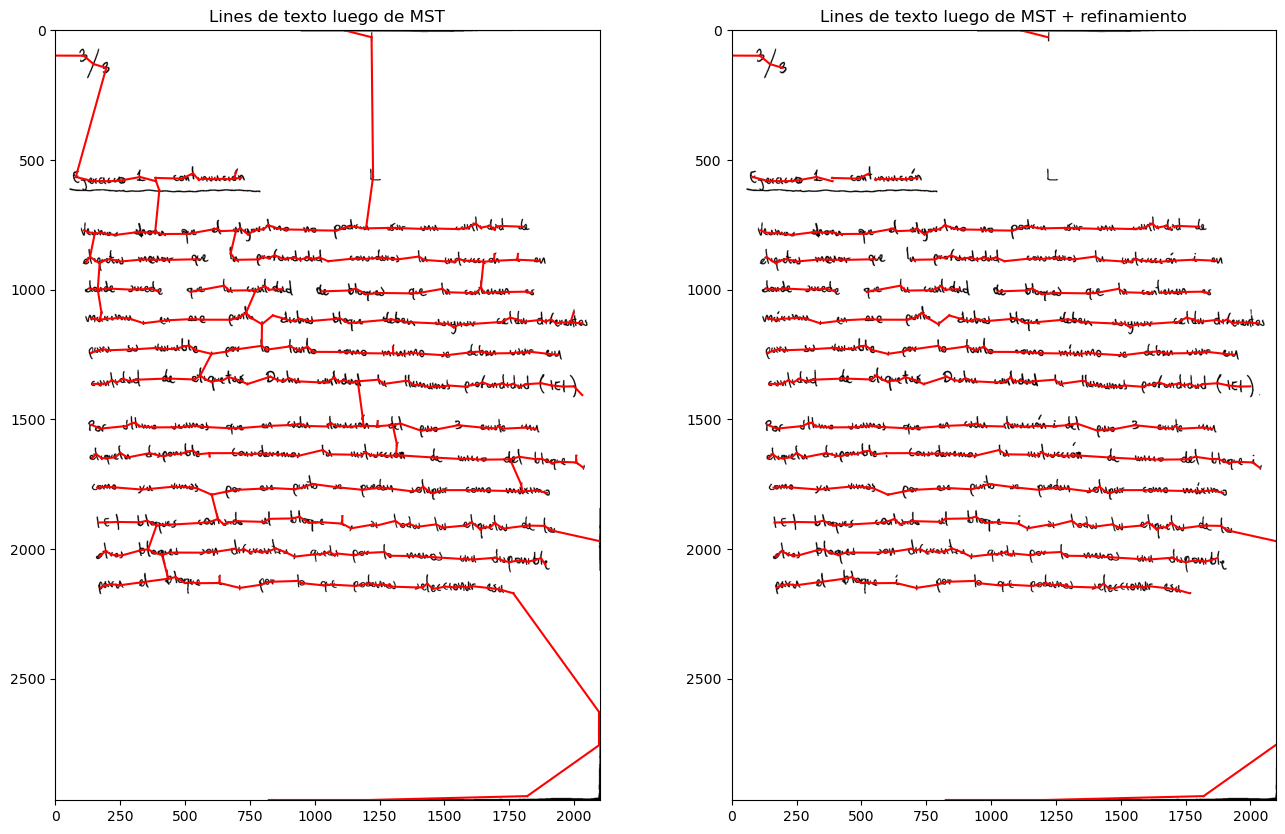

In [517]:
# Mostramos la imagen binarizada con las CC de la imagen unidas luego de MST, y las mismas
# luego de aplicar el refinamiento.

# Ploteo:

figura, plots = plt.subplots(1, 2, figsize=(16,10))

plots[0].imshow(img_morf, cmap='gray')
plots[0].set_title("Lines de texto luego de MST")

plots[1].imshow(img_morf, cmap='gray')
plots[1].set_title("Lines de texto luego de MST + refinamiento")

cant_labels = len(props)

# Ploteo salida del MST sin refinar:
for l1 in range(0,cant_labels-1):
    for l2 in range(l1+1,cant_labels):
        if mst_graph_mat[l1,l2] != 0:
            
            l1_x = props[l1].centroid[1]
            l1_y = props[l1].centroid[0]
            l2_x = props[l2].centroid[1]
            l2_y = props[l2].centroid[0]
            plots[0].plot([l1_x,l2_x],[l1_y,l2_y],color='red')

# Ploteo salida del MST refinada: 
mst_ref_graph_mat = MST_refinamiento_basico(mst_graph_mat, props)
for l1 in range(0,cant_labels-1):
    for l2 in range(l1+1,cant_labels):
        if mst_ref_graph_mat[l1,l2] != 0:
            
            l1_x = props[l1].centroid[1]
            l1_y = props[l1].centroid[0]
            l2_x = props[l2].centroid[1]
            l2_y = props[l2].centroid[0]
            plots[1].plot([l1_x,l2_x],[l1_y,l2_y],color='red')

plt.show()

if guardar_resultados_intermedios:
    
    # Save the full figure...
    figura.savefig(path_resultados_intermedios + 'full_mst_ref.png')

    # Save plot 1
    extent = plots[0].get_window_extent().transformed(figura.dpi_scale_trans.inverted())
    figura.savefig(path_resultados_intermedios + "mst.png", bbox_inches=extent)

    # Save plor 2
    extent = plots[1].get_window_extent().transformed(figura.dpi_scale_trans.inverted())
    figura.savefig(path_resultados_intermedios + "mst_ref.png", bbox_inches=extent)


In [518]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

# Función para obtener una lista por cada CC a nivel de grafo(representa una linea de texto)
# conteniendo todas las etiquetas que participan en esa linea de texto.
def obtener_CC_graph(mst_ref_graph_mat, props, debug=False):
    
    cant_cc, labels = connected_components(
        csgraph=csr_matrix(mst_ref_graph_mat),
        directed=False,
        return_labels=True
    )
    
    cant_labels = len(props)    
    cc_list = np.empty((cant_labels,),dtype=object)
    
    for label in range(0,cant_labels):
        
        cc_index = labels[label]
        if cc_list[cc_index] == None:
            cc_list[cc_index] = [label]
        else:
            cc_list[cc_index].append(label)
    
    cc_list_result = []
    for lista in cc_list:
        if lista != None:
            cc_list_result.append(lista)
    
    if debug:
        print(f"Cant_labels = {cant_labels}")
        print(f"Cant_cc = {cant_cc}")
        print(f"labels = \n{labels}")
        print(f"cc_list_result = \n{cc_list_result}")
    
    return cc_list_result

# print(obtener_CC_graph(mst_ref_graph_mat, props))

# Devuele una lista con coordenas de inicio y fin (tanto vertical como horizontal)
# del rectángulo que contiene una linea de texto. Cada rectángulo es escrito en
# formato: bbox = (min_row, min_col, max_row, max_col).
def obtener_CC_box(CC_graph_list, props):
    
    boxes_list = []
    
    for cc in CC_graph_list:
    
        y_sup = props[cc[0]].bbox[2]
        y_inf = props[cc[0]].bbox[0]
        x_sup = props[cc[0]].bbox[3]
        x_inf = props[cc[0]].bbox[1]

        for label in cc:

            # bbox = (min_row, min_col, max_row, max_col)
            if props[label].bbox[2] > y_sup:
                y_sup = props[label].bbox[2]
            if props[label].bbox[0] < y_inf:
                y_inf = props[label].bbox[0]
            if props[label].bbox[3] > x_sup:
                x_sup = props[label].bbox[3]
            if props[label].bbox[1] < x_inf:
                x_inf = props[label].bbox[1]

        box_lims = (y_inf, x_inf, y_sup, x_sup) # (min_row, min_col, max_row, max_col)
        boxes_list.append(box_lims)
    
    return boxes_list


<ipython-input-519-baf05027ad3f>:39: UserWarning: recortes/27.png is a low contrast image
  imsave(path_recorte, img_recorte)
<ipython-input-519-baf05027ad3f>:39: UserWarning: recortes/44.png is a low contrast image
  imsave(path_recorte, img_recorte)
<ipython-input-519-baf05027ad3f>:39: UserWarning: recortes/45.png is a low contrast image
  imsave(path_recorte, img_recorte)
<ipython-input-519-baf05027ad3f>:39: UserWarning: recortes/46.png is a low contrast image
  imsave(path_recorte, img_recorte)
<ipython-input-519-baf05027ad3f>:39: UserWarning: recortes/47.png is a low contrast image
  imsave(path_recorte, img_recorte)
<ipython-input-519-baf05027ad3f>:39: UserWarning: recortes/48.png is a low contrast image
  imsave(path_recorte, img_recorte)
<ipython-input-519-baf05027ad3f>:39: UserWarning: recortes/49.png is a low contrast image
  imsave(path_recorte, img_recorte)
<ipython-input-519-baf05027ad3f>:39: UserWarning: recortes/50.png is a low contrast image
  imsave(path_recorte, img_r

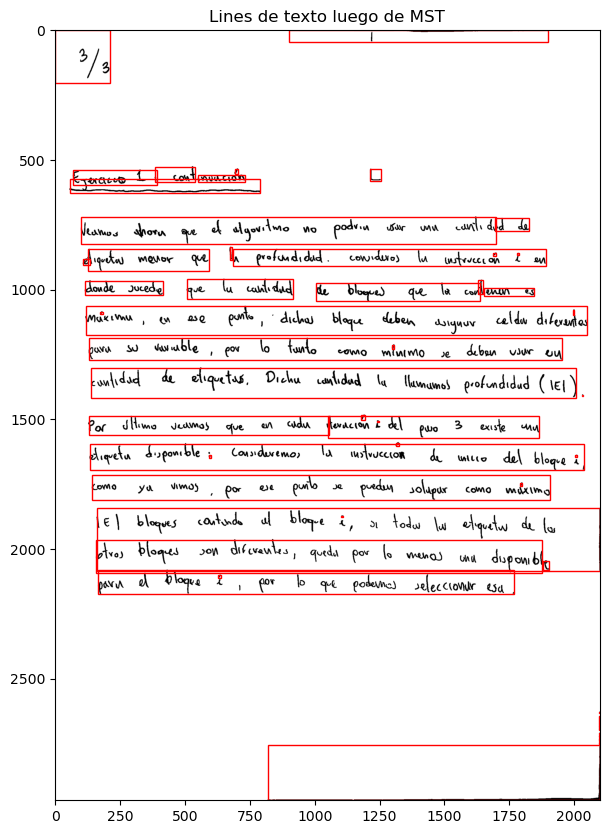

In [519]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread, imsave

# Mostramos los recortes sobre la imagen binariza y los guardamos en una carpeta
# para posteriormente procesarlos por un OCR.

path_recorte_base = "recortes/"

CC_graph_list = obtener_CC_graph(mst_ref_graph_mat, props)
boxes_list = obtener_CC_box(CC_graph_list, props)

# Ploteo:

figura, plots = plt.subplots(1, 1, figsize=(16,10))

plots.imshow(img_morf, cmap='gray')
plots.set_title("Lines de texto luego de MST")

for index_rec, box in enumerate(boxes_list):
    
    # (min_row, min_col, max_row, max_col)
    y_sup = box[2]
    y_inf = box[0]
    x_sup = box[3]
    x_inf = box[1]
    delta_x = x_sup - x_inf
    delta_y = y_sup - y_inf
    
    # Create a Rectangle patch: (x_pos, y_pos, x_size, y_size)
    rect_patch = patches.Rectangle((x_inf, y_inf), delta_x, delta_y, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    plots.add_patch(rect_patch)
    
    # guardar recorte
    path_recorte = path_recorte_base + str(index_rec) + ".png"
    img_recorte = img_morf[y_inf:y_sup,x_inf:x_sup]*255
    imsave(path_recorte, img_recorte)
    

plt.show()

if guardar_resultados_intermedios:
    
    # Save the full figure...
    figura.savefig(path_resultados_intermedios + 'full_rectanngulo.png')

    # Save plot 1
    extent = plots.get_window_extent().transformed(figura.dpi_scale_trans.inverted())
    figura.savefig(path_resultados_intermedios + "rectangulo.png", bbox_inches=extent)
